# Introduction to Deep Learning

Author : Jérémie Jakubowicz

Date : 08/23/2017

The first part of this tutorial follows [this page](https://www.tensorflow.org/tutorials/mnist/beginners/)

## The perceptron

A *perceptron* is a function $x\in\mathbb{R}^m\mapsto f(w\cdot x + b)$ where $w\in\mathbb{R}^m$ is a vector with components called *weights* and $b\in\mathbb{R}$ is a scalar called *bias*. Function $f:\mathbb{R}\to\mathbb{R}$ is called *activation function*. Percpetron can be represented this way:

<img src='figures/neurone_artificiel.png' alt='artificial neuron' height=512 width=512></img>

The following *sigmoid function* is popular as activation function.
$$\sigma:s\mapsto\frac{1}{1+\exp-s}$$

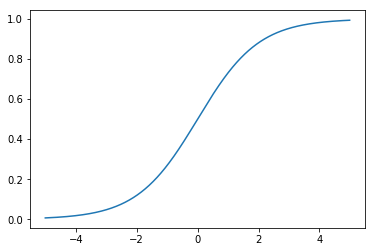

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
s = np.arange(-5,5,0.01)
plt.plot(s, 1./(1+np.exp(-s)))

# Following code centers images
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Having n data points $(x_i, y_i)$ where $x_i\in\mathbb{R}^m$ and $y_i\in\{0,1\}$ is binary, we wish to *learn* the weights of the neuron, *i.e.* minimize a function having the form:
$$\sum_{i=1}^n l(f(w\cdot x_i +b), y_i)$$

Notice that, when $f=\sigma$, and $l(y,y') = -y'\log y$, *i.e.* $\log$-`loss` function, the problème is in fact equivalent to logistic regression.

## First steps in `tensorflow`

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(type(mnist.train))
for x in [mnist.train, mnist.validation, mnist.test]:
    print(x.num_examples)

<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
55000
5000
10000


In [4]:
mnist.train.images.shape

(55000, 784)

In [5]:
mnist.train.labels.shape

(55000, 10)

Each image is 28x28 pixels (784 pixels) that are stacked in a 784-dim vector. There are $55\, 000$ images in `mnist.train`, vector `mnist.train.images` has size `(55000,784)`. The label corresponds to the number present in the image. `one-hot` encoding is used which gives a size `10` vector.

In the multiclass setting $\log$-loss writes:
$$l(y,y') = -\sum_{j=1}^p y'_j\log y_j$$
It is also referred to as `cross-entropy`.

Each of the 10 perceptrons are going to give $s_j = w_j\cdot x + b_j$ and from that we deduce $y_j$ using softmax, *i.e.*:
$$y_j = \frac{\exp s_j}{\sum_{j'=1}^{J}\exp s_{j'}}$$
We get back logistic regression when $J=2$, except here $J=10$.
With a concise notation:
$$
y = \mathrm{softmax}(s)
$$

Stacking the 10 weights $w_j$ in a matrix $W$ having size $10\times784$ and all $b_j$  in  a $10\times 1$ vector, we have:
$$ y =\mathrm{softmax}(W\cdot x + b) $$
where $x$ stands for a $1\times 784$ vector representing an image.

This is the tensorflow way:

In [6]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

Notice the `None` that says: we don't know yet how many images

Then the model:

In [2]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

NameError: name 'tf' is not defined

In [8]:
y

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

Optimisation problem writes:
$$\inf_{W,b} R_n(W,b) = \sum_{i=1}^n\mathrm{crossentropy}(\mathrm{softmax}(W\cdot x_i+b),y_i)$$

So let's define $\mathrm{crossentropy}$ with `tensorflow`:

In [9]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

$W$ and $b$ are solved with gradient descent:
$$W_{t+1} = W_t - \gamma \nabla_W R_n(W_t,b_t)$$
$$b_{t+1} = b_t - \gamma \nabla_b R_n(W_t,b_t)$$

In [10]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Initializing we get:

In [11]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

*Accuracy* is defined as:
$$\frac1n\sum_{i=1}^n 1\{\mathrm{argmax}(W\cdot x_i +b) = \mathrm{argmax}(y_i)\}$$

In [12]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9171


Less than $8\%$ errors: learning has happened! However, we are still for from the [state of the art](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

Let us look at W

In [13]:
Wnd = sess.run(W.value())

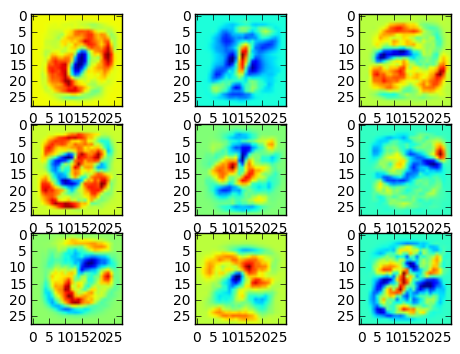

In [14]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Wnd[:,i].reshape([28,28]))

## Perceptron Multi-Couches

Now let us use several layers

<img src='figures/single-layer-perceptron-network.png' alt='neural layer' height=384 width=384></img>

Formally, it is not a big change from a single perceptron:
$$y = f^{\otimes J}(W\cdot x + b)$$

We can now stack layers like one compose functions

<img src='figures/multilayer-perceptrons.png' alt='stacked layers' height=384 width=384></img>

What follows comes from [this page](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py)

In [15]:
# Parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess1:
    sess1.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess1.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess1.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Epoch: 0001 cost= 179.826162345
Epoch: 0002 cost= 40.353936456
Epoch: 0003 cost= 24.998076785
Epoch: 0004 cost= 17.506988875
Epoch: 0005 cost= 12.446736570
Epoch: 0006 cost= 9.236861153
Epoch: 0007 cost= 7.108253222
Epoch: 0008 cost= 5.270819859
Epoch: 0009 cost= 3.958663956
Epoch: 0010 cost= 3.054218576
Epoch: 0011 cost= 2.237660584
Epoch: 0012 cost= 1.752751776
Epoch: 0013 cost= 1.347809892
Epoch: 0014 cost= 1.103918589
Epoch: 0015 cost= 0.881122994
Optimization Finished!
0.9424


Better but still not state of the art. One might be tempted to use more hidden layers but that would not work...

First take away message: Deep Learning is not multilayer perceptron.

## Convolutionnal Neural Networks

What follows comes from [this page](https://www.tensorflow.org/tutorials/mnist/pros/)

Watchout the ReLU activation functions, hence the need to carefully initialize the weights (dead neurons)

In [16]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [18]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### First layer (convolution)

$5\times 5$ windows and $32$ features each

In [19]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

We first reshape the images as 2d vectors

In [20]:
x_image = tf.reshape(x, [-1,28,28,1])

In [21]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

Output is 28x28x32 (because of 0-padding), otherwise it would be (24x24x32)

### Second layer (max-pooling)

In [22]:
h_pool1 = max_pool_2x2(h_conv1)

Output is 14x14x32

### Third layer (convolution)

In [23]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

### Fourth layer (max-pooling)

In [24]:
h_pool2 = max_pool_2x2(h_conv2)

Output is 7x7x64

### Fifth layer (fully connected)

In [25]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout for the training

In [26]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Output (softmax)

In [27]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [26]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 100, training accuracy 0.9
step 200, training accuracy 0.88
step 300, training accuracy 0.96
step 400, training accuracy 0.96
step 500, training accuracy 0.9
step 600, training accuracy 0.96
step 700, training accuracy 0.96
step 800, training accuracy 0.96
step 900, training accuracy 0.94
step 1000, training accuracy 0.94
step 1100, training accuracy 0.94
step 1200, training accuracy 0.98
step 1300, training accuracy 1
step 1400, training accuracy 1
step 1500, training accuracy 1
step 1600, training accuracy 0.96
step 1700, training accuracy 1
step 1800, training accuracy 0.98
step 1900, training accuracy 0.98
step 2000, training accuracy 0.98
step 2100, training accuracy 0.98
step 2200, training accuracy 0.98
step 2300, training accuracy 0.98
step 2400, training accuracy 0.96
step 2500, training accuracy 0.98
step 2600, training accuracy 1
step 2700, training accuracy 1
step 2800, training accuracy 0.96
step 2900, training accuracy 0.96
step 3000, t

Still not state of the art but a serious progress!

## Neural nets for text

### word2vec

What follows comes from [this page](https://www.tensorflow.org/tutorials/word2vec/)

<img src='figures/predict_next_word.png' alt='next word' height=512 width=512></img>

Too hard, $V$ has order of magnitude $10^4$. First trick: negative sampling

<img src='figures/noise-classifier.png' alt='negative sampling' height=512 width=512></img>

In [30]:
vocabulary_size = 50000
embedding_size = 200

In [32]:
import math
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

Now each word is represented by an int. A text is therefore a sequence of ints

In [33]:
# Placeholders for inputs
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

Ints are mapped thanks to

In [34]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

We can then compute the loss

In [36]:
num_sampled = 10
# Compute the NCE loss, using a sample of the negative labels each time.
loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, vocabulary_size))

Then we derive the optimization problem

In [37]:
# We use the SGD optimizer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

And we are ready to learn